In [1]:
import numpy as np
import time
import sys
import os
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d, interp2d
from multiprocessing import Pool, Manager
import antisym_func
import error_bar
from importlib import reload
import normal_corner
reload(error_bar)

<module 'error_bar' from '/Users/liuzhaoning/Desktop/Today/antisym_observability/pycode/error_bar.py'>

In [2]:
#calculate the Pk_A for certain models at input redshift array
def read_model_data(DIR, zeta, T_vir, R_mfp, SMOOTHING_SCALE):
    #read in the normalized zeta
    DIR_zeta = DIR + '/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/normalized_zeta.npz'%(zeta, T_vir, R_mfp, SMOOTHING_SCALE)
    if os.path.exists(DIR_zeta): 
        data = np.load(DIR_zeta)
        z_zeta_interp_array = data['z']; zeta_z_interp_array = data['zeta_z']
        zeta_z_func = interp1d(z_zeta_interp_array, zeta_z_interp_array, kind = 'cubic')
    else:
        print('file %s not found'%DIR_zeta); sys.exit()
        
    #read in the history of HI fraction and dx_HI/dz
    DIR_history = DIR + '/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/history.npz'%(zeta, T_vir, R_mfp, SMOOTHING_SCALE)
    if os.path.exists(DIR_history):
        data = np.load(DIR_history)
        z_array_history = list(data['z_array_history']); HI_history = list(data['HI_history'])
        z_dxHdz_history = list(data['z_dxHdz_history']); dxHdz_history = list(data['dxHdz_history'])
    else:
        print('file %s not found'%DIR_history); sys.exit()
    
    #read in the average density of the neutral region
    DIR_rhoHI = DIR + '/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/rhoHI_over_rho0.npz'%(zeta, T_vir, R_mfp, SMOOTHING_SCALE)
    if os.path.exists(DIR_rhoHI):
        data = np.load(DIR_rhoHI)
        z_array_HIrho = list(data['z_array_HIrho']); rhoHI_over_rho0_array = list(data['rhoHI_over_rho0_array'])
        HIrho_over_rho0_interp = interp1d(z_array_HIrho, rhoHI_over_rho0_array, kind = 'cubic')
    else:
        print('file %s not found'%DIR_rhoHI); sys.exit()
    
    #load in the Bubble mass functions
    DIR_BMF = DIR + '/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/BMF_map.npz'%(zeta, T_vir, R_mfp, SMOOTHING_SCALE)
    if os.path.exists(DIR_BMF):
        data = np.load(DIR_BMF)
        z_grid = list(data['z_grid']); m_grid = list(data['m_grid']); BMF_map = list(data['BMF_map'])       
        BMF_interp = interp2d(m_grid, z_grid, BMF_map, kind = 'cubic')
    else:
        print('file %s not found'%DIR_BMF); sys.exit()
    
    #load in the unsmoothed antisymmetric cross-correlation data
    DIR_xiHICO = DIR + '/zeta%05.5g_Tvir%05.5g_Rmfp%05.5g_SMO%03.3g/xi_A_HICO_unsmoothed_map.npz'%(zeta, T_vir, R_mfp, SMOOTHING_SCALE)
    if os.path.exists(DIR_xiHICO):
        data = np.load(DIR_xiHICO)
        z_grid = list(data['z_grid']); r12_grid = list(data['r12_grid']); xi_A_HICO_map = list(data['xi_A_HICO_map'])       
        xi_A_HICO_unsmoothed_interp = interp2d(r12_grid, z_grid, xi_A_HICO_map, kind = 'cubic')
    else:
        print('file %s not found'%DIR_xiHICO); sys.exit()
    return zeta_z_func, z_array_history, HI_history, z_dxHdz_history, dxHdz_history, HIrho_over_rho0_interp, \
            BMF_interp, xi_A_HICO_unsmoothed_interp

#compute the HI-CO antisymmetric power spectrum
def Pk_A_HICO_computation(z_array, kh_array, SMOOTHING_Pk, xi_A_HICO_unsmoothed_interp):
    tick = time.time()
    #smooth the antisymmetric cross-correlation
    r12_limit = 150
    r12_smoothed_grid = np.zeros(100); r12_smoothed_grid[0:30] = np.linspace(0.1, 5, 30)
    r12_smoothed_grid[30:100] = np.linspace(5, r12_limit, 71)[1:71]
    xi_A_HICO_smoothed_func_array = [] #[z](r12)
    for z in z_array:
        xi_A_HICO_smoothed_array = []
        for r12 in r12_smoothed_grid:
            xi_A_HICO_smoothed_array.append(antisym_func.xi_A_HICO_smoothing(z, r12, xi_A_HICO_unsmoothed_interp, SMOOTHING_Pk)[0])
        xi_A_HICO_smoothed_func_array.append(interp1d(r12_smoothed_grid, xi_A_HICO_smoothed_array, kind = 'cubic'))
    
    #Fourier transformation to compute the smoothed antisymmetric power spectrum
    k_array = kh_array * antisym_func.hlittle
    Pk_A_map = [] #[z][kh]
    for ct in range(len(z_array)):
        Pk_A_map.append([])
        for k in k_array:
            Pk_A_map[-1].append(antisym_func.Pk_A_cal(k, xi_A_HICO_smoothed_func_array[ct], min(r12_smoothed_grid), max(r12_smoothed_grid)))
    print('Pk_A_HICO computation cost %3.3g mins'%((time.time() - tick) / 60))
    return Pk_A_map #[z_array][kh_array] #in muK^2 h^-3 Mpc^3

#compute the HI-CO symmetric power spectrum
def Pk_S_HICO_computation(z_array, kh_array, BMF_func):
    tick = time.time()
    #compute the symmetric cross-correlation betwwen 21cm and CO line
    r12_limit = 150
    r12_grid = np.zeros(100); r12_grid[0:30] = np.linspace(0.1, 5, 30)
    r12_grid[30:100] = np.linspace(5, r12_limit, 71)[1:71]
    xi_S_HICO_func_array = [] #[z](r12)
    for z in z_array:
        xi_S_HICO_array = []
        BMF_func_z = lambda m: BMF_func(m, z)
        for r12 in r12_grid:
            xi_S_HICO_array.append(antisym_func.xi_S_HICO(z, r12, zeta_z_func, HIrho_over_rho0_interp, BMF_func_z, M_max, T_vir, mu))
        xi_S_HICO_func_array.append(interp1d(r12_grid, xi_S_HICO_array, kind = 'cubic'))
    
    #compute the correspondent power spectrum
    k_array = kh_array * antisym_func.hlittle
    Pk_S_map = []
    for ct in range(len(z_array)):
        Pk_S_map.append([])
        for k in k_array:
            Pk_S_map[-1].append(antisym_func.Pk_S(k, xi_S_HICO_func_array[ct], min(r12_grid), max(r12_grid)))
    print('Pk_S_HICO computation cost %3.3g mins'%((time.time() - tick) / 60))
    return Pk_S_map

def Pk_auto_21_computation(z_array, kh_array, zeta_z_func, HIrho_over_rho0_func, BMF_func, M_max, T_vir, mu):
    tick = time.time()
    #compute the symmetric cross-correlation betwwen 21cm and CO line
    r12_limit = 150
    r12_grid = np.zeros(100); r12_grid[0:30] = np.linspace(0.1, 5, 30)
    r12_grid[30:100] = np.linspace(5, r12_limit, 71)[1:71]
    xi_auto_21_func_array = [] #[z](r12)
    for z in z_array:
        xi_auto_21_array = []
        BMF_func_z = lambda m: BMF_func(m, z)
        for r12 in r12_grid:
            xi_auto_21_array.append(antisym_func.xi_auto_21(z, r12, zeta_z_func, HIrho_over_rho0_func, BMF_func_z, M_max, T_vir, mu))
        xi_auto_21_func_array.append(interp1d(r12_grid, xi_auto_21_array, kind = 'cubic'))
    
    #compute the correspondent power spectrum
    k_array = kh_array * antisym_func.hlittle
    Pk_auto_21_map = []
    for ct in range(len(z_array)):
        Pk_auto_21_map.append([])
        for k in k_array:
            Pk_auto_21_map[-1].append(antisym_func.Pk_S(k, xi_auto_21_func_array[ct], min(r12_grid), max(r12_grid)))
    print('Pk_auto_21 computation cost %3.3g mins'%((time.time() - tick) / 60))
    return Pk_auto_21_map

def Pk_auto_CO_computation(z_array, kh_array, T_vir, mu):
    tick = time.time()
    k_array = kh_array * antisym_func.hlittle
    Pk_auto_CO_map = []
    for ct in range(len(z_array)):
        z = z_array[ct]
        Pk_auto_CO_map.append([])
        for k in k_array:
            Pk_auto_CO_map[-1].append(antisym_func.Pk_auto_CO(z, k, T_vir, mu))
    print('Pk_auto_CO computation cost %3.3g mins'%((time.time() - tick) / 60))
    return Pk_auto_CO_map

def dPkA_dparameter(z_array, kh_array, zeta, T_vir, R_mfp, SMOOTHING_SCALE, PARA_NUM, Delta_parameter, SMOOTHING_Pk, DIR):
    if PARA_NUM == 0:
        PARA_1 = [zeta - 0.5 * Delta_parameter, T_vir, R_mfp]; PARA_2 = [zeta + 0.5 * Delta_parameter, T_vir, R_mfp]
    elif PARA_NUM == 1:
        PARA_1 = [zeta, T_vir - 0.5 * Delta_parameter, R_mfp]; PARA_2 = [zeta, T_vir + 0.5 * Delta_parameter, R_mfp]
    elif PARA_NUM == 2:
        PARA_1 = [zeta, T_vir, R_mfp - 0.5 * Delta_parameter]; PARA_2 = [zeta, T_vir, R_mfp + 0.5 * Delta_parameter]
    
    tick = time.time()
    #read the data of model1 and compute its Pk_A_HICO
    zeta_z_func, z_array_history, HI_history, z_dxHdz_history, dxHdz_history, HIrho_over_rho0_interp, \
    BMF_func, xi_A_HICO_unsmoothed_interp = read_model_data(DIR, PARA_1[0], PARA_1[1], PARA_1[2], SMOOTHING_SCALE)
    Pk_A_HICO_map_1 = Pk_A_HICO_computation(z_array, kh_array, SMOOTHING_Pk, xi_A_HICO_unsmoothed_interp)
    #read the data of model2 and compute its Pk_A_HICO
    zeta_z_func, z_array_history, HI_history, z_dxHdz_history, dxHdz_history, HIrho_over_rho0_interp, \
    BMF_func, xi_A_HICO_unsmoothed_interp = read_model_data(DIR, PARA_2[0], PARA_2[1], PARA_2[2], SMOOTHING_SCALE)
    Pk_A_HICO_map_2 = Pk_A_HICO_computation(z_array, kh_array, SMOOTHING_Pk, xi_A_HICO_unsmoothed_interp)
    
    dPkA_dpara_map = []
    for i in range(len(z_array)):
        dPkA_dpara_map.append([])
        for j in range(len(kh_array)):
            dPkA_dpara_map[-1].append((Pk_A_HICO_map_2[i][j] - Pk_A_HICO_map_1[i][j]) / (Delta_parameter))
    print('dPkA_dPARA of PARA_INDEX %d cost %3.3g mins'%(PARA_NUM, (time.time() - tick) / 60))
    return dPkA_dpara_map

def error_PkA_HICO_computation(t_int, z_array, kh_array, SMOOTHING_Pk, NUM_PATCH, MEASUREMENT, Pk_auto_CO_map, Pk_auto_21_map, Pk_A_HICO_map, Pk_S_HICO_map):
    """
    t_int : s, the observation time of each redshift
    z_array : the array of the redshifts we are interested
    kh_array : h/Mpc, the array of the measured scales
    SMOOTHING_Pk : Mpc, the computation box size
    NUM_PATCH : the number of boxes in a survey
    P_CO_array : [muK]^2[Mpc/h]^3, the array of CO auto power spectrums
    P_21_array : [muK]^2[Mpc/h]^3, the array of 21 auto power spectrums
    Pk_S_array : [muK]^2[Mpc/h]^3, the array of 21-CO cross power spectrums
    Pk_A_array : [muK]^2[Mpc/h]^3, the array of 21-CO antisymmetric cross power spectrums
    """
    
    #set the parameters
    delta_nu_21 = 5.4e-3; delta_nu_CO = 79.3e-3 #MHz
    
    if MEASUREMENT == 0: #parameters of SKA1 
        N_feeds_21 = 2 # num of polarizations
        N_feeds_CO = 197 * 2 # num of antennas * num of polarizations
        L_min_21 = 60 ; L_max_21 = 1000 #m
    elif MEASUREMENT == 1: #parameters of SKA2
        N_feeds_21 = 2 * 4 # fourtimes of the antennas than SKA1-low
        N_feeds_CO = 1970 * 2 # num of antennas * num of polarizations
        L_min_21 = 34; L_max_21 = 1000 #m
    elif MEASUREMENT == 2: #parameters of SKA2-advanced
        N_feeds_21 = 2 * 4 # fourtimes of the antennas than SKA1-low
        N_feeds_CO = 4925 * 2 # num of antennas * num of polarizations
        L_min_21 = 34; L_max_21 = 1000 #m
    
    error_auto_CO_map = []; error_auto_21_map = []
    error_PkA_HICO_map = []; error_PkS_HICO_map = []
    VAR_PkA_map = []; S_over_N_map = []
    kh_min_array = []; kh_max_array = []; confidence_array = [];#for each redshift
    
    for i in range(len(z_array)):
        z = z_array[i]
        Tsys_21 = 280. * ( (1. + z) / 7.4 )**(2.3) * 1e6; Tsys_CO = 25 * 1e6 # muK
        D_21 = 35; D_CO = 15 # meter 
        Omega_beam_21 = (1.22 * error_bar.lambda_21 * (1 + z) / D_21 ) ** 2
        Omega_beam_CO = (1.22 * error_bar.lambda_CO * (1 + z) / D_CO ) ** 2 # radians
        Tsys_21 = 280. * ( (1. + z) / 7.4 )**(2.3) * 1e6; Tsys_CO = 25 * 1e6 #muK
        Omega_patch = (SMOOTHING_Pk * antisym_func.hlittle / error_bar.X(z)) ** 2 #radians
        Omega_survey = NUM_PATCH * Omega_patch
        B_21 = SMOOTHING_Pk * antisym_func.hlittle / error_bar.Y(z, error_bar.nu_21) # Mhz
        B_CO = SMOOTHING_Pk * antisym_func.hlittle / error_bar.Y(z, error_bar.nu_CO) # Mhz
        delta_D = SMOOTHING_Pk * antisym_func.hlittle # Mpc/h
        k_limits = error_bar.reliable_k_range(z, Omega_beam_CO, Omega_patch, delta_nu_CO, delta_D, L_min_21, L_max_21, delta_nu_21)
        #print(k_limits)
        error_auto_CO_map.append([]); error_auto_21_map.append([])
        error_PkA_HICO_map.append([]); error_PkS_HICO_map.append([])
        VAR_PkA_map.append([]); S_over_N_map.append([])
        for j in range(len(kh_array)):
            kh = kh_array[j]
            delta_kh = kh * ((kh_array[1] / kh_array[0]) - 1)
            error_auto_CO_map[-1].append(error_bar.error_CO_auto(kh, delta_kh, k_limits, Pk_auto_CO_map[i][j], z, Tsys_CO, \
                                        Omega_patch, NUM_PATCH, B_CO, Omega_beam_CO, delta_nu_CO, N_feeds_CO, t_int))
            error_auto_21_map[-1].append(error_bar.error_21_auto(kh, delta_kh, k_limits, Pk_auto_21_map[i][j], z, Tsys_21, \
                                        Omega_patch, NUM_PATCH, Omega_beam_21, B_21, N_feeds_21, t_int))
            error_PkA_HICO_map[-1].append(error_bar.error_21_CO_cross(kh, delta_kh, k_limits, Pk_A_HICO_map[i][j], z, Omega_patch, NUM_PATCH, delta_D))
            error_PkS_HICO_map[-1].append(error_bar.error_21_CO_cross(kh, delta_kh, k_limits, Pk_S_HICO_map[i][j], z, Omega_patch, NUM_PATCH, delta_D))
            VAR_PkA_map[-1].append(9/20/np.pi * error_PkA_HICO_map[-1][-1][0] ** 2 + error_auto_21_map[-1][-1][0] * \
                                  error_auto_CO_map[-1][-1][0] - error_PkS_HICO_map[-1][-1][0] ** 2)
            S_over_N_map[-1].append(abs(Pk_A_HICO_map[i][j]) / VAR_PkA_map[i][j]**0.5)
            #print(error_auto_CO_map[-1][-1], error_auto_21_map[-1][-1])
            #print('%03.3g, %03.3g, %03.3g, %03.3g, %03.3g, %03.3g, %03.3g'%(z, kh, error_auto_CO_map[-1][-1][0], error_auto_21_map[-1][-1][0], error_PkA_HICO_map[-1][-1][0], error_PkS_HICO_map[-1][-1][0], VAR_PkA_map[-1][-1]))
            #compute the confidence
        square_sum = np.sum(np.array(S_over_N_map[-1])**2)
        free_degree = len(S_over_N_map[-1])-1
        confidence = error_bar.significance_level(square_sum, free_degree)
        kh_min = kh_array[0]
        kh_max = kh_array[free_degree]
        while free_degree > 1:
            square_sum -= S_over_N_map[-1][free_degree]**2
            free_degree -= 1 
            temp_confidence = error_bar.significance_level(square_sum, free_degree)
            #print(square_sum, free_degree, temp_confidence)
            if (temp_confidence > confidence):
                confidence = temp_confidence
                kh_max = kh_array[free_degree]
        kh_min_array.append(kh_min); kh_max_array.append(kh_max); confidence_array.append(confidence)
    return VAR_PkA_map, S_over_N_map, kh_min_array, kh_max_array, confidence_array

def fisher_matrix(VAR_PkA_map, dPkA_dpara_map_array, z_array, kh_array):
    MATRIX = [[0 for i in range(3)] for j in range(3)]#for the three parameters: zeta, Tvir, Rmfp
    for i in range(3):
        for j in range(3):
            for z_index in range(len(z_array)):
                for kh_index in range(len(kh_array)):
                    MATRIX[i][j] += (1 / VAR_PkA_map[z_index][kh_index]) * \
                                    dPkA_dpara_map_array[i][z_index][kh_index] * dPkA_dpara_map_array[j][z_index][kh_index]
    return MATRIX

def covariance_matrix(FISHER_MATRIX):
    return np.linalg.linalg.inv(FISHER_MATRIX)

In [5]:
#3 point and 10000 hour for each

#the fiducial parameters
zeta = 25; T_vir = 3e4; R_mfp = 50; SMOOTHING_SCALE = 384
mu = 1.22 if T_vir < 9.99999e3 else 0.6
M_max = antisym_func.RtoM(R_mfp)

#read in the fiducial model
DIR = '/Users/liuzhaoning/Desktop/Today/antisym_observability/data/antisym_observability/xi_A_HICO'
zeta_z_func, z_array_history, HI_history, z_dxHdz_history, dxHdz_history, HIrho_over_rho0_interp, \
BMF_func, xi_A_HICO_unsmoothed_interp = read_model_data(DIR, zeta, T_vir, R_mfp, SMOOTHING_SCALE)

#choose the redshift we are observing
z_floor = antisym_func.dxHdz_To_z(0.34, M_max, zeta_z_func, T_vir, mu, z_dxHdz_history, dxHdz_history)[1]
z_top = antisym_func.dxHdz_To_z(0.25, M_max, zeta_z_func, T_vir, mu, z_dxHdz_history, dxHdz_history)[1]
z_array_observe = np.linspace(z_floor, z_top, 3); dxHdz_array_observe = []; xH_array_observe = []
for z in z_array_observe:
    dxHdz_array_observe.append(interp1d(z_dxHdz_history, dxHdz_history, kind='cubic')(z))
    xH_array_observe.append(interp1d(z_array_history, HI_history, kind='cubic')(z))

#set the power spectrum we want to observe
kh_array = np.logspace(np.log10(0.1),np.log10(0.6), 16)
#set the Smoothing scale of Pk_A computation
SMOOTHING_Pk = 384 #a similar comving distance with the frequency bandwidth 

#compute the statistics
Pk_A_HICO_map = Pk_A_HICO_computation(z_array_observe, kh_array, SMOOTHING_Pk, xi_A_HICO_unsmoothed_interp)
Pk_S_HICO_map = Pk_S_HICO_computation(z_array_observe, kh_array, BMF_func)
Pk_auto_21_map = Pk_auto_21_computation(z_array_observe, kh_array, zeta_z_func, HIrho_over_rho0_interp, BMF_func, M_max, T_vir, mu)
Pk_auto_CO_map = Pk_auto_CO_computation(z_array_observe, kh_array, T_vir, mu)

#compute the dPkA_dpara
dPkA_dzeta_map = dPkA_dparameter(z_array_observe, kh_array, zeta, T_vir, R_mfp, SMOOTHING_SCALE, 0, 2, SMOOTHING_Pk, DIR)
dPkA_dTvir_map = dPkA_dparameter(z_array_observe, kh_array, zeta, T_vir, R_mfp, SMOOTHING_SCALE, 1, 0.2e4, SMOOTHING_Pk, DIR)
dPkA_dRmfp_map = dPkA_dparameter(z_array_observe, kh_array, zeta, T_vir, R_mfp, SMOOTHING_SCALE, 2, 2, SMOOTHING_Pk, DIR)

Pk_A_HICO computation cost 0.733 mins
Pk_S_HICO computation cost 0.504 mins
Pk_auto_21 computation cost 0.452 mins
Pk_auto_CO computation cost 0.00465 mins
Pk_A_HICO computation cost 0.735 mins
Pk_A_HICO computation cost 0.702 mins
dPkA_dPARA of PARA_INDEX 0 cost 1.44 mins
Pk_A_HICO computation cost 0.629 mins
Pk_A_HICO computation cost 0.654 mins
dPkA_dPARA of PARA_INDEX 1 cost 1.28 mins
Pk_A_HICO computation cost 0.747 mins
Pk_A_HICO computation cost 0.868 mins
dPkA_dPARA of PARA_INDEX 2 cost 1.62 mins


In [6]:
z_array_observe, xH_array_observe, dxHdz_array_observe

(array([7.88371508, 8.27462121, 8.66552734]),
 [array(0.24886933), array(0.3729498), array(0.47901292)],
 [array(0.34002283), array(0.2937269), array(0.24993217)])

In [13]:
#compute the uncertainties
t_int = 3000 * 3600 #seconds
NUM_PATCH = 75
MEASUREMENT = 0 #SKA1
VAR_PkA_map, S_over_N, kh_min_array, kh_max_array, confidence_array = error_PkA_HICO_computation(t_int, z_array_observe, kh_array, SMOOTHING_Pk, NUM_PATCH, MEASUREMENT, Pk_auto_CO_map, Pk_auto_21_map, Pk_A_HICO_map, Pk_S_HICO_map)
FISHER_MATRIX = fisher_matrix(VAR_PkA_map, [dPkA_dzeta_map, dPkA_dTvir_map, dPkA_dRmfp_map], z_array_observe, kh_array)
COVARIANCE_MATRIX_0 = covariance_matrix(FISHER_MATRIX)

#compute the uncertainties
NUM_PATCH = 200
MEASUREMENT = 1 #SKA2
VAR_PkA_map, S_over_N, kh_min_array, kh_max_array, confidence_array = error_PkA_HICO_computation(t_int, z_array_observe, kh_array, SMOOTHING_Pk, NUM_PATCH, MEASUREMENT, Pk_auto_CO_map, Pk_auto_21_map, Pk_A_HICO_map, Pk_S_HICO_map)
FISHER_MATRIX = fisher_matrix(VAR_PkA_map, [dPkA_dzeta_map, dPkA_dTvir_map, dPkA_dRmfp_map], z_array_observe, kh_array)
COVARIANCE_MATRIX_1 = covariance_matrix(FISHER_MATRIX)

#compute the uncertainties
NUM_PATCH = 300
MEASUREMENT = 2 #SKA2
VAR_PkA_map, S_over_N, kh_min_array, kh_max_array, confidence_array = error_PkA_HICO_computation(t_int, z_array_observe, kh_array, SMOOTHING_Pk, NUM_PATCH, MEASUREMENT, Pk_auto_CO_map, Pk_auto_21_map, Pk_A_HICO_map, Pk_S_HICO_map)
FISHER_MATRIX = fisher_matrix(VAR_PkA_map, [dPkA_dzeta_map, dPkA_dTvir_map, dPkA_dRmfp_map], z_array_observe, kh_array)
COVARIANCE_MATRIX_2 = covariance_matrix(FISHER_MATRIX)

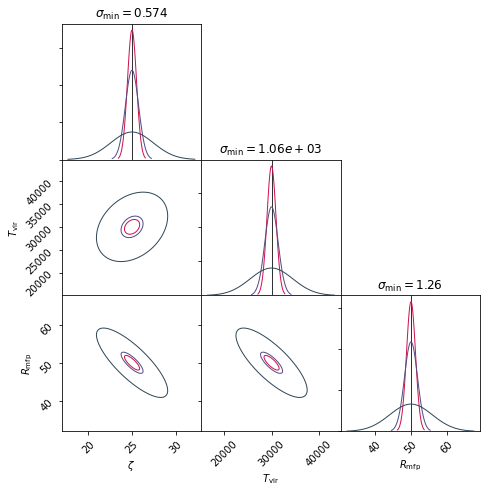

In [14]:
reload(normal_corner)
color_list = ['#D1124D', '#544C87', '#2F4858']
PARA_MEAN =[25, 3e4, 50]; PARA_NAME = ['$\zeta$', '$T_\mathrm{vir}$', '$R_\mathrm{mfp}$']
#from 2 to 0, Because of the range of PDF axs
fig1 = normal_corner.normal_corner(np.array(COVARIANCE_MATRIX_2), np.array(PARA_MEAN), PARA_NAME, color = color_list[0], \
                                   figsize=(7.5,7.5), )
fig1 = normal_corner.normal_corner(np.array(COVARIANCE_MATRIX_1), np.array(PARA_MEAN), PARA_NAME, color = color_list[1], fig = fig1)
fig1 = normal_corner.normal_corner(np.array(COVARIANCE_MATRIX_0), np.array(PARA_MEAN), PARA_NAME, color = color_list[2], fig = fig1)
plt.show()
fig1.savefig('../figures/fisher_information_t%05.5ghour_analytical_zeta%03.3g_Tvir%3.3g_Rmfp%03.3g_dHIdz%3.3g_%3.3g_%3.3g_.png'%(t_total / 3600, zeta, T_vir, R_mfp, dxHdz_array_observe[0], dxHdz_array_observe[1], dxHdz_array_observe[2]), bbox_inches='tight', dpi=200)

In [ ]:
antisym_func.dxHdz_To_z(0.34, M_max, zeta_z_func, T_vir, mu, z_dxHdz_history, dxHdz_history)[1]

In [15]:
#only one point at dxHdz = 0.34, and 10000 hour observation time

#the fiducial parameters
zeta = 25; T_vir = 3e4; R_mfp = 50; SMOOTHING_SCALE = 384
mu = 1.22 if T_vir < 9.99999e3 else 0.6
M_max = antisym_func.RtoM(R_mfp)

#read in the fiducial model
DIR = '/Users/liuzhaoning/Desktop/Today/antisym_observability/data/antisym_observability/xi_A_HICO'
zeta_z_func, z_array_history, HI_history, z_dxHdz_history, dxHdz_history, HIrho_over_rho0_interp, \
BMF_func, xi_A_HICO_unsmoothed_interp = read_model_data(DIR, zeta, T_vir, R_mfp, SMOOTHING_SCALE)

#choose the redshift we are observing
z_floor = antisym_func.dxHdz_To_z(0.34, M_max, zeta_z_func, T_vir, mu, z_dxHdz_history, dxHdz_history)[1]
z_top = antisym_func.dxHdz_To_z(0.25, M_max, zeta_z_func, T_vir, mu, z_dxHdz_history, dxHdz_history)[1]
z_array_observe = [z_floor]; dxHdz_array_observe = []
for z in z_array_observe:
    dxHdz_array_observe.append(interp1d(z_dxHdz_history, dxHdz_history, kind='cubic')(z))

#set the power spectrum we want to observe
kh_array = np.logspace(np.log10(0.1),np.log10(0.6), 16)
#set the Smoothing scale of Pk_A computation
SMOOTHING_Pk = 384 #a similar comving distance with the frequency bandwidth 

#compute the statistics
Pk_A_HICO_map = Pk_A_HICO_computation(z_array_observe, kh_array, SMOOTHING_Pk, xi_A_HICO_unsmoothed_interp)
Pk_S_HICO_map = Pk_S_HICO_computation(z_array_observe, kh_array, BMF_func)
Pk_auto_21_map = Pk_auto_21_computation(z_array_observe, kh_array, zeta_z_func, HIrho_over_rho0_interp, BMF_func, M_max, T_vir, mu)
Pk_auto_CO_map = Pk_auto_CO_computation(z_array_observe, kh_array, T_vir, mu)

#compute the dPkA_dpara
dPkA_dzeta_map = dPkA_dparameter(z_array_observe, kh_array, zeta, T_vir, R_mfp, SMOOTHING_SCALE, 0, 2, SMOOTHING_Pk, DIR)
dPkA_dTvir_map = dPkA_dparameter(z_array_observe, kh_array, zeta, T_vir, R_mfp, SMOOTHING_SCALE, 1, 0.2e4, SMOOTHING_Pk, DIR)
dPkA_dRmfp_map = dPkA_dparameter(z_array_observe, kh_array, zeta, T_vir, R_mfp, SMOOTHING_SCALE, 2, 2, SMOOTHING_Pk, DIR)

Pk_A_HICO computation cost 0.222 mins
Pk_S_HICO computation cost 0.183 mins
Pk_auto_21 computation cost 0.172 mins
Pk_auto_CO computation cost 0.00156 mins
Pk_A_HICO computation cost 0.266 mins
Pk_A_HICO computation cost 0.307 mins
dPkA_dPARA of PARA_INDEX 0 cost 0.573 mins
Pk_A_HICO computation cost 0.21 mins
Pk_A_HICO computation cost 0.177 mins
dPkA_dPARA of PARA_INDEX 1 cost 0.388 mins
Pk_A_HICO computation cost 0.267 mins
Pk_A_HICO computation cost 0.249 mins
dPkA_dPARA of PARA_INDEX 2 cost 0.516 mins


In [16]:
#compute the uncertainties
t_int = 3000 * 3600 #seconds
NUM_PATCH = 75
MEASUREMENT = 0 #SKA1
VAR_PkA_map, S_over_N, kh_min_array, kh_max_array, confidence_array = error_PkA_HICO_computation(t_int, z_array_observe, kh_array, SMOOTHING_Pk, NUM_PATCH, MEASUREMENT, Pk_auto_CO_map, Pk_auto_21_map, Pk_A_HICO_map, Pk_S_HICO_map)
FISHER_MATRIX = fisher_matrix(VAR_PkA_map, [dPkA_dzeta_map, dPkA_dTvir_map, dPkA_dRmfp_map], z_array_observe, kh_array)
COVARIANCE_MATRIX_0 = covariance_matrix(FISHER_MATRIX)

#compute the uncertainties
NUM_PATCH = 200
MEASUREMENT = 1 #SKA2
VAR_PkA_map, S_over_N, kh_min_array, kh_max_array, confidence_array = error_PkA_HICO_computation(t_int, z_array_observe, kh_array, SMOOTHING_Pk, NUM_PATCH, MEASUREMENT, Pk_auto_CO_map, Pk_auto_21_map, Pk_A_HICO_map, Pk_S_HICO_map)
FISHER_MATRIX = fisher_matrix(VAR_PkA_map, [dPkA_dzeta_map, dPkA_dTvir_map, dPkA_dRmfp_map], z_array_observe, kh_array)
COVARIANCE_MATRIX_1 = covariance_matrix(FISHER_MATRIX)

#compute the uncertainties
NUM_PATCH = 300
MEASUREMENT = 2 #SKA2
VAR_PkA_map, S_over_N, kh_min_array, kh_max_array, confidence_array = error_PkA_HICO_computation(t_int, z_array_observe, kh_array, SMOOTHING_Pk, NUM_PATCH, MEASUREMENT, Pk_auto_CO_map, Pk_auto_21_map, Pk_A_HICO_map, Pk_S_HICO_map)
FISHER_MATRIX = fisher_matrix(VAR_PkA_map, [dPkA_dzeta_map, dPkA_dTvir_map, dPkA_dRmfp_map], z_array_observe, kh_array)
COVARIANCE_MATRIX_2 = covariance_matrix(FISHER_MATRIX)

In [17]:
COVARIANCE_MATRIX_0[0,1] / COVARIANCE_MATRIX_0[0,0]**0.5 / COVARIANCE_MATRIX_0[1,1]**0.5

-0.04928604011441209

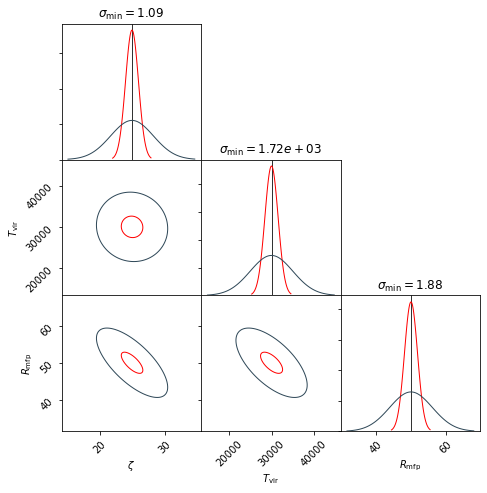

In [18]:
reload(normal_corner)
color_list = ['#D1124D', '#544C87', '#2F4858']
PARA_MEAN =[25, 3e4, 50]; PARA_NAME = ['$\zeta$', '$T_\mathrm{vir}$', '$R_\mathrm{mfp}$']
#from 2 to 0, Because of the range of PDF axs
#fig1 = normal_corner.normal_corner(np.array(COVARIANCE_MATRIX_2), np.array(PARA_MEAN), PARA_NAME, color = color_list[0], figsize=(7.5,7.5), )
fig1 = normal_corner.normal_corner(np.array(COVARIANCE_MATRIX_1), np.array(PARA_MEAN), PARA_NAME, color = 'red', figsize=(7.5,7.5))
fig1 = normal_corner.normal_corner(np.array(COVARIANCE_MATRIX_0), np.array(PARA_MEAN), PARA_NAME, color = color_list[2], fig = fig1)
plt.show()
fig1.savefig('../figures/fisher_information_t%05.5ghour_analytical_zeta%03.3g_Tvir%3.3g_Rmfp%03.3g_dHIdz%3.3g_.png'%(t_total / 3600, zeta, T_vir, R_mfp, dxHdz_array_observe[0]), bbox_inches='tight', dpi=200)

array([[ 1.19159192e+00, -1.00260254e+02],
       [-1.00260254e+02,  2.94620645e+06]])

In [56]:
#history_computation
def history_computation(zeta, T_vir, R_mfp):
    #print(zeta, T_vir, R_mfp)
    tick1 = time.time()
    M_max = antisym_func.RtoM(R_mfp)
    NUM = 50; z_zeta_interp_array = np.linspace(5.5, 13.5, NUM); zeta_z_interp_array = []
    for i in range(NUM):
        zeta_z_interp_array.append(antisym_func.zeta_z(z_zeta_interp_array[i], zeta, T_vir, mu))
    zeta_z_func = interp1d(z_zeta_interp_array, zeta_z_interp_array, kind = 'cubic')
    z_history = np.linspace(6, 12, 100); HI_history = [];
    for z in z_history:
        HI_history.append(1 - antisym_func.bar_Q(z, M_max, zeta_z_func, T_vir, mu, antisym_func.PARA_z(z, M_max, zeta_z_func, T_vir, mu)))
    [z_dxHdz_history, dxHdz_history] = antisym_func.dxH_dz_cal(z_history, HI_history)
    #max_speed = max(dxHdz_history); turning_redshift = z_dxHdz_history[dxHdz_history.index(max_speed)]
    tick2 = time.time()
    print('history comuputation at zeta=%3.3g T_vir=%3.3g cost %3.3g seconds'%(zeta, T_vir, tick2 - tick1))
    return [z_history, HI_history, z_dxHdz_history, dxHdz_history]

#compute the history constraint
def fisher_history_constraint(covariance_zeta_Tvir, zeta_mean, Tvir_mean, Rmfp_mean, SIGMA):
    if SIGMA == 1: chi_square, alpha = 2.3, 1.52
    elif SIGMA == 2: chi_square, alpha = 6.17, 2.48
    #solve the ellipse equation
    def ellipse(delta_x, covariance, chi_square):
        sigma_x = covariance[0,0] ** 0.5; sigma_y = covariance[1,1] ** 0.5; sigma_xy = covariance[0,1]
        rho = sigma_xy / sigma_x / sigma_y
        a = 1 / sigma_y**2; b = 2 * rho * delta_x / sigma_x / sigma_y; 
        c = (delta_x/sigma_x)**2 - (1 - rho**2) * chi_square
        if b**2 - 4 * a * c > 0:
            temp_term = (b**2 - 4 * a * c) ** 0.5
        elif b**2 - 4 * a * c == 0:
            temp_term = 0
        else:
            print('ERROR! %3.3g should be positive'%(b**2 - 4 * a * c))
        delta_y_1 = (-b + temp_term) / 2 / a; delta_y_2 = (-b - temp_term) / 2 / a
        return delta_y_1, delta_y_2
    
    HI_history, dxHdz_history = [], []
    sigma_zeta = covariance_zeta_Tvir[0,0] ** 0.5
    NUM = 30
    for delta_zeta in np.linspace(-alpha * sigma_zeta * 0.99, alpha * sigma_zeta * 0.99, NUM):
        for delta_Tvir in ellipse(delta_zeta, covariance_zeta_Tvir, chi_square):
            zeta = zeta_mean + delta_zeta; Tvir = Tvir_mean + delta_Tvir; Rmfp = Rmfp_mean
            z_history_temp, HI_history_temp, z_dxHdz_history_temp, dxHdz_history_temp = history_computation(zeta, Tvir, Rmfp)
            HI_history.append(HI_history_temp); dxHdz_history.append(dxHdz_history_temp)
    z_history_mean, HI_history_mean, z_dxHdz_history_mean, dxHdz_history_mean = history_computation(zeta_mean, Tvir_mean, Rmfp_mean)
    
    HI_history_max, HI_history_min, dxHdz_history_max, dxHdz_history_min = [], [], [], []
    for ct in range(len(z_history_mean)):
        HI_temp_array = []
        for i in range(2*NUM):
            HI_temp_array.append(HI_history[i][ct])
        HI_history_max.append(max(HI_temp_array)); HI_history_min.append(min(HI_temp_array))
    for ct in range(len(z_dxHdz_history_mean)):
        dxHdz_temp_array = []
        for i in range(2*NUM):
            dxHdz_temp_array.append(dxHdz_history[i][ct])
        dxHdz_history_max.append(max(dxHdz_temp_array)); dxHdz_history_min.append(min(dxHdz_temp_array))
    return z_history_mean, HI_history_mean, HI_history_max, HI_history_min, \
           z_dxHdz_history_mean, dxHdz_history_mean, dxHdz_history_max, dxHdz_history_min

In [57]:
z_history_mean_1, HI_history_mean_1, HI_history_max_1, HI_history_min_1, \
z_dxHdz_history_mean_1, dxHdz_history_mean_1, dxHdz_history_max_1, dxHdz_history_min_1 \
= fisher_history_constraint(COVARIANCE_MATRIX_1[0:2, 0:2], 25, 3e4, 50, 1)

z_history_mean_0, HI_history_mean_0, HI_history_max_0, HI_history_min_0, \
z_dxHdz_history_mean_0, dxHdz_history_mean_0, dxHdz_history_max_0, dxHdz_history_min_0 \
= fisher_history_constraint(COVARIANCE_MATRIX_0[0:2, 0:2], 25, 3e4, 50, 1)

history comuputation at zeta=23.4 T_vir=3.02e+04 cost 10.1 seconds
history comuputation at zeta=23.4 T_vir=2.95e+04 cost  11 seconds
history comuputation at zeta=23.5 T_vir=3.09e+04 cost 9.42 seconds
history comuputation at zeta=23.5 T_vir=2.89e+04 cost 10.3 seconds
history comuputation at zeta=23.6 T_vir=3.12e+04 cost 9.28 seconds
history comuputation at zeta=23.6 T_vir=2.85e+04 cost 10.3 seconds
history comuputation at zeta=23.7 T_vir=3.15e+04 cost 9.01 seconds
history comuputation at zeta=23.7 T_vir=2.83e+04 cost 9.89 seconds
history comuputation at zeta=23.8 T_vir=3.17e+04 cost 8.73 seconds
history comuputation at zeta=23.8 T_vir=2.81e+04 cost 10.1 seconds
history comuputation at zeta=23.9 T_vir=3.19e+04 cost 8.67 seconds
history comuputation at zeta=23.9 T_vir=2.79e+04 cost 10.5 seconds
history comuputation at zeta= 24 T_vir=3.2e+04 cost 9.21 seconds
history comuputation at zeta= 24 T_vir=2.78e+04 cost 10.6 seconds
history comuputation at zeta=24.2 T_vir=3.22e+04 cost 8.56 seconds

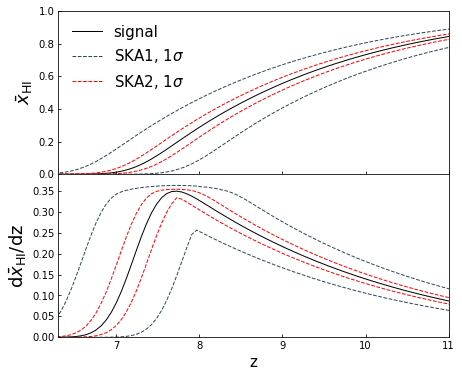

In [65]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(7,6))
fig.subplots_adjust(hspace=0)
    
axs[0].tick_params(direction='in',length=3)
axs[0].plot(z_history_mean_1, HI_history_mean_1, color = 'black', lw=1, ls='-', label = 'signal')
axs[0].plot(z_history_mean_0, HI_history_max_0, color = color_list[2], lw=1, ls='--', label = 'SKA1, 1$\sigma$')
axs[0].plot(z_history_mean_0, HI_history_min_0, color = color_list[2], lw=1, ls='--')
axs[0].plot(z_history_mean_1, HI_history_max_1, color = 'red', lw=1, ls='--', label = 'SKA2, 1$\sigma$')
axs[0].plot(z_history_mean_1, HI_history_min_1, color = 'red', lw=1, ls='--')
axs[0].set_ylabel(r'$\bar{x}_{\mathrm{HI}}$',fontsize=18)
axs[0].set_ylim(0,1)
axs[0].legend(loc=2,fontsize=15, frameon = False)
  
axs[1].plot(z_dxHdz_history_mean_1, dxHdz_history_mean_1, color = 'black', lw=1, ls='-')
axs[1].plot(z_dxHdz_history_mean_1, dxHdz_history_max_1, color = 'red', lw=1, ls='--')
axs[1].plot(z_dxHdz_history_mean_1, dxHdz_history_min_1, color = 'red', lw=1, ls='--')
axs[1].plot(z_dxHdz_history_mean_0, dxHdz_history_max_0, color = color_list[2], lw=1, ls='--')
axs[1].plot(z_dxHdz_history_mean_0, dxHdz_history_min_0, color = color_list[2], lw=1, ls='--')
axs[1].set_ylim(0.0,0.39); axs[1].set_xlim(6.3,11)
axs[1].set_ylabel(r'd$\bar{x}_{\mathrm{HI}}$/dz',fontsize=18)
axs[1].set_xlabel('z',fontsize=15)
axs[1].tick_params(direction='in',length=3)

plt.savefig('../figures/history_model_denpendent_fisher_constraint.png', bbox_inches='tight', dpi=200)

In [69]:
np.pi * (35 / 2)**2 * 224 * 4

862053.0241450393

In [71]:
384 * antisym_func.hlittle / error_bar.X(8)

0.04186640264760305

In [80]:
(384 * antisym_func.hlittle / error_bar.X(8))**2 / 2 / np.pi 

0.000278966095214216